<a href="https://colab.research.google.com/github/wig190029/dupliart_id/blob/gh-pages/Latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#replace this with your custom dataset
!gdown --id 18uB0qAuN2dtHn64kVAWiZHc5NfsNPEpB
!unzip /content/5cats-256.zip

Downloading...
From: https://drive.google.com/uc?id=18uB0qAuN2dtHn64kVAWiZHc5NfsNPEpB
To: /content/5cats-256.zip
100% 779k/779k [00:00<00:00, 104MB/s]
Archive:  /content/5cats-256.zip
replace 5cats-256/img_220.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: 5cats-256/img_220.jpg   
  inflating: 5cats-256/img_219.png   
  inflating: 5cats-256/img_218.png   
  inflating: 5cats-256/img_217.jpg   
  inflating: 5cats-256/img_216.png   
  inflating: 5cats-256/img_215.jpg   
  inflating: 5cats-256/img_214.jpg   
  inflating: 5cats-256/img_212.jpg   
  inflating: 5cats-256/img_211.jpg   
  inflating: 5cats-256/img_210.jpg   
  inflating: 5cats-256/img_209.jpg   
  inflating: 5cats-256/img_208.jpg   
  inflating: 5cats-256/img_207.jpg   
  inflating: 5cats-256/img_206.jpg   
  inflating: 5cats-256/img_205.jpg   
  inflating: 5cats-256/img_204.jpg   
  inflating: 5cats-256/img_203.jpg   
  inflating: 5cats-256/img_201.jpg   
  inflating: 5cats-256/img_200.jpg   
  inflating: 5cats-256/

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We'll start by importing the relevant Keras libraries that we'll be using.

In [22]:
%tensorflow_version 1.x

In [23]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#"/content/gdrive/My Drive/101_ObjectCategories/airplanes/image_0019.jpg"

In [24]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

Forwarding image through network

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

shape of x:  (1, 224, 224, 3)
data type:  float32


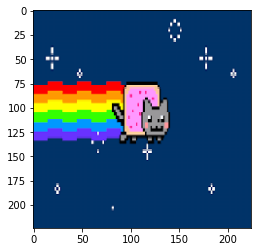

In [26]:
img, x = load_image("/content/5cats-256/image_0002.jpg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

In [27]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

In [28]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

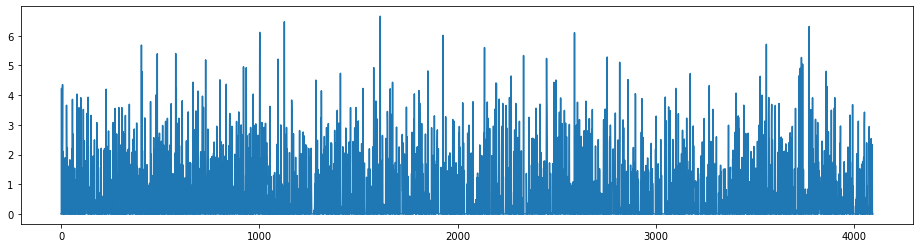

In [29]:
img, x = load_image("/content/5cats-256/image_0002.jpg")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [30]:
images_path = '/content/5cats-256'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 55 images to analyze


In [31]:
import time
tic = time.clock()


features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 55. Time: 0.0002 seconds.
finished extracting features for 55 images


In [32]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=55)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=55, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [33]:
pca_features = pca.transform(features)

Now for the reverse search

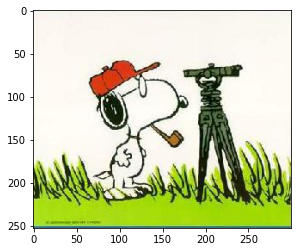

In [34]:
import random

# grab a random query image
query_image_idx = int(len(images) * random.random())

# let's display the image
img = image.load_img(images[query_image_idx])
plt.imshow(img)

In [35]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

In [36]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:5]

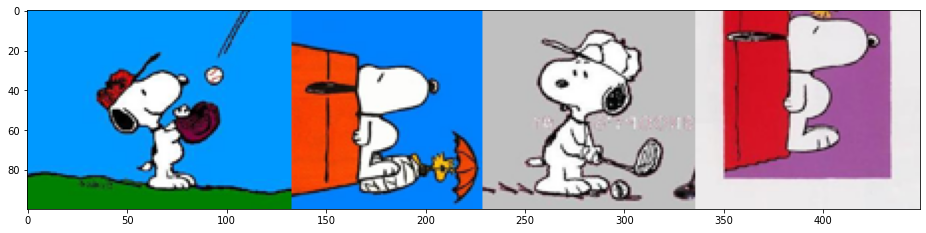

In [37]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)


diff style

Mounted at /content/gdrive


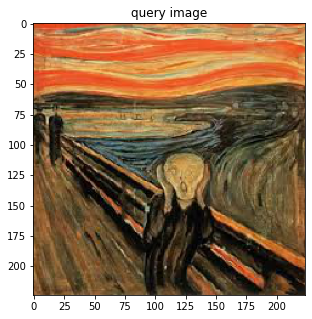

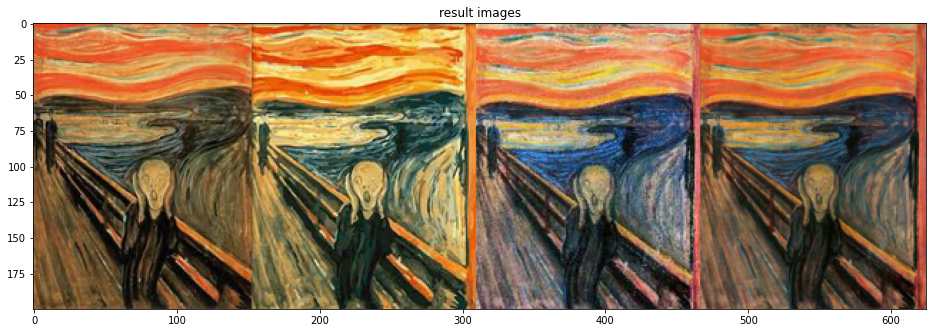

In [38]:
from PIL import Image as im 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# load image and extract features
new_image, x = load_image("/content/gdrive/My Drive/Tocheck/tocheck.jpg")
new_features = feat_extractor.predict(x)

# project it into pca space
new_pca_features = pca.transform(new_features)[0]

# calculate its distance to all the other images pca feature vectors
distances = [ distance.cosine(new_pca_features, feat) for feat in pca_features ]
idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[0:4]  # grab first 5
results_image = get_concatenated_images(idx_closest, 200)

# display the results
plt.figure(figsize = (5,5))
plt.imshow(new_image)
plt.title("query image")

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

w, h = 512, 512
img = im.fromarray(results_image, 'RGB')
img.save('my.jpg')
plt.savefig('/content/gdrive/My Drive/Received/yes.jpg')
img.show()
